# Alzheimer’s Detection with Slice Selection + ViT + CDR-based Severity Classification

### *Second Improvement Deliverable*

---

## **Group Members**
- **Sheraz Waseem** – *26100026*  
- **Umair Amir** – *26100148*  

---

## Dataset: OASIS-2

We used the **OASIS-2** dataset comprising brain MRI volumes along with dementia labels and **CDR scores (Clinical Dementia Rating)**.

**Key Details:**
- **Format:** 3D volumes in `.hdr` / `.img` format  
- **Binary Classes:**  
  - `0`: Non-demented  
  - `1`: Demented  
- **CDR-based Subclasses:**  
  - `0`   No dementia  
  - `0.5` Very mild  
  - `1`   Mild  
  - `2+`  Moderate  

---

## Architecture Overview

Our model performs both binary and multi-class classification:

### 1. Slice Selector (Squeeze-and-Excitation Module)  
A learnable attention mechanism to select the **3 most important slices** out of the full MRI volume along the sagittal depth.

- Compresses spatial info via mean pooling  
- Projects attention weights through a small MLP  
- Outputs 3 soft-weighted “composite” slices  
- Records the hard-argmax slice indices for visualization  

### 2. Vision Transformer (Binary Dementia Classification)  
A pretrained **ViT** from Hugging Face fine-tuned to predict **Non-demented vs Demented** from the selected RGB slices.

### 3. Severity Head (CDR-based 3-Class Classifier)  
An additional linear head on the ViT CLS token to predict dementia severity (`very mild` / `mild` / `moderate`) for scans labeled “Demented.”

---

## Pipeline

### 1. Data Preprocessing
- Load and min-max normalize 3D volumes via nibabel  
- Extract depth slices → tensor shape `(D,1,H,W)`  
- Map Excel CDR → severity labels (`-1`, 0, 1, 2)  

### 2. Dataset Construction
- Each sample yields:  
  - `volume`: full-stack tensor  
  - `labels`: binary 0/1  
  - `severity`: −1/0/1/2  
- `severity == −1` excludes sample from severity loss  

### 3. Model Definition
- `SliceSelector` learns slice-importance  
- `ViTForImageClassification` head for binary CE loss  
- `Linear` severity head for 3-class CE loss  

### 4. Training
- **Total Loss** = binary CE + severity CE (for CDR>0)  
- Optimizer: AdamW, lr=1e-5, weight_decay=1e-4  
- Logged per-epoch training & validation metrics  

---

## Evaluation: 4-Class Severity Prediction

We combine the two heads to yield 4 final classes:

```text
if binary_head == 0 → class 0 (No dementia)  
else → class = 1 + argmax(severity_head)  → {1: very mild, 2: mild, 3: moderate}

## Connecting to Google Drive to Access Dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Extracting dataset zip file

In [8]:
import tarfile

file_path = '/content/drive/MyDrive/KerasModel/OAS2_RAW_PART1.tar.gz'
extract_path = '/content/oasis_data'

with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)

print("Extraction complete.")

Extraction complete.


## Removing "Converted" samples

In [ ]:
import os, shutil, pandas as pd

XL_PATH   = "/content/drive/MyDrive/KerasModel/oasis_longitudinal_demographics-8d83e569fa2e2d30.xlsx"
DATA_ROOT = "/content/oasis_data/OAS2_RAW_PART1"
TRASH_DIR = "/content/converted_scans_backup"  

df = pd.read_excel(XL_PATH)

converted_ids = df.loc[df["Group"].eq("Converted"), "MRI ID"].unique().tolist()
print(f"Found {len(converted_ids)} converted visits")

os.makedirs(TRASH_DIR, exist_ok=True)

for mri_id in converted_ids:
    src = os.path.join(DATA_ROOT, mri_id)  
    if not os.path.isdir(src):
        print(f"[WARN] {src} not found, skipping")
        continue

    dst = os.path.join(TRASH_DIR, mri_id)
    shutil.move(src, dst)                  

    print(f"✓ removed {mri_id}")

print("Done!")

Found 37 converted visits
✓ removed OAS2_0018_MR1
✓ removed OAS2_0018_MR3
✓ removed OAS2_0018_MR4
✓ removed OAS2_0020_MR1
✓ removed OAS2_0020_MR2
✓ removed OAS2_0020_MR3
✓ removed OAS2_0031_MR1
✓ removed OAS2_0031_MR2
✓ removed OAS2_0031_MR3
✓ removed OAS2_0041_MR1
✓ removed OAS2_0041_MR2
✓ removed OAS2_0041_MR3
✓ removed OAS2_0054_MR1
✓ removed OAS2_0054_MR2
✓ removed OAS2_0092_MR1
✓ removed OAS2_0092_MR2
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0103_MR1 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0103_MR2 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0103_MR3 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0118_MR1 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0118_MR2 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0127_MR1 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0127_MR2 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0127_MR3 no

## Complete Pipeline

  0%|          | 0/336 [00:00<?, ?it/s]

Usable scans: 193
max depth = 256
154 train | 39 val


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: umair-amir (umair-amir-lums) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.490800,2.091108,0.538462,0.511834
2,2.173100,1.173747,0.615385,0.586938
3,1.328200,1.027680,0.589744,0.437552
4,0.920500,1.050576,0.589744,0.437552
5,0.718500,1.235017,0.589744,0.437552
6,0.670200,1.158304,0.666667,0.611529
7,0.596200,1.202361,0.666667,0.642013
8,0.567300,1.242964,0.692308,0.674556
9,0.517900,1.174494,0.692308,0.663818
10,0.504200,1.273795,0.717949,0.716400


Train 4-class accuracy : 0.857
Train 4-class weighted-F1: 0.848


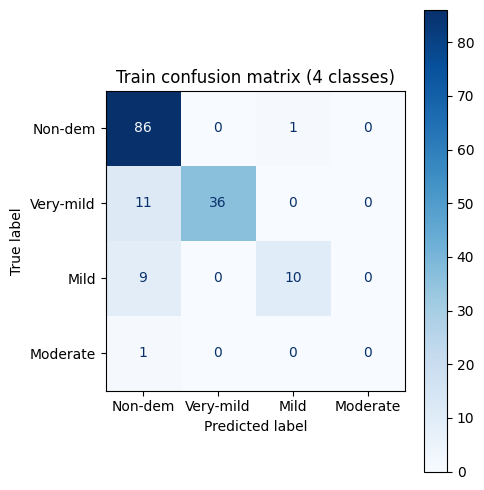

Validation 4-class accuracy : 0.718
Validation 4-class weighted-F1: 0.691


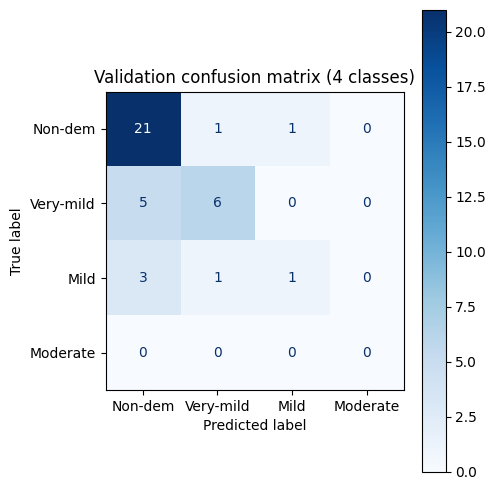

In [ ]:

!pip -q install -U "transformers>=4.41.0" "huggingface_hub>=0.23.0" accelerate \
                nibabel pandas scikit-learn tqdm pillow


import os, json, numpy as np, pandas as pd, nibabel as nib, torch
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt, numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    ViTConfig,
    ViTForImageClassification,
    ViTImageProcessor,
    TrainingArguments,
    Trainer,
    DefaultDataCollator,
)
from sklearn.metrics import accuracy_score, f1_score

EXCEL = "/content/drive/MyDrive/KerasModel/oasis_longitudinal_demographics-8d83e569fa2e2d30.xlsx"
ROOT  = "/content/oasis_data/OAS2_RAW_PART1"
CFG   = "/content/vit_2class.json"

cfg_json = {
    "_name_or_path": "google/vit-base-patch16-224-in21k",
    "architectures": ["ViTForImageClassification"],
    "image_size": 224,
    "patch_size": 16,
    "hidden_size": 768,
    "num_hidden_layers": 12,
    "num_attention_heads": 12,
    "intermediate_size": 3072,
    "hidden_act": "gelu",
    "initializer_range": 0.02,
    "layer_norm_eps": 1e-12,
    "qkv_bias": True,
    "num_channels": 3,
    "id2label": {"0": "Nondemented", "1": "Demented"},
    "label2id": {"Nondemented": 0, "Demented": 1},
}
with open(CFG, "w") as f: json.dump(cfg_json, f)


def three_views_rgb(hdr_path):
    """Return a PIL RGB image (224 × 224) built from the middle axial,
    coronal, sagittal slices. Handles 3-D or 4-D NIfTI volumes."""
    vol = nib.load(hdr_path).get_fdata().astype(np.float32)

    vol = np.squeeze(vol)
    if vol.ndim == 4:                       
        vol = vol[..., 0]
    if vol.ndim != 3:
        raise ValueError(f"Unexpected volume shape {vol.shape}")

    cx, cy, cz = np.array(vol.shape) // 2
    slices = [vol[cx, :, :], vol[:, cy, :], vol[:, :, cz]]

    def to_pil(slice2d):
        s_min, s_max = slice2d.min(), slice2d.max()
        if s_max > s_min:
            sl = ((slice2d - s_min) / (s_max - s_min) * 255).astype(np.uint8)
        else:
            sl = np.zeros_like(slice2d, dtype=np.uint8)
        return Image.fromarray(sl).resize((224, 224), Image.BILINEAR)

    triplet = [np.array(to_pil(s)) for s in slices]     
    stacked = np.stack(triplet, axis=-1)                
    return Image.fromarray(stacked)


df = pd.read_excel(EXCEL)

df = df[df["Group"].isin(["Nondemented", "Demented"])][["MRI ID", "Group", "CDR"]]

def cdr_to_severity(cdr):
    if pd.isna(cdr) or cdr == 0:
        return -1          
    if cdr == 0.5:
        return 0           
    if cdr == 1:
        return 1           
    return 2               

df["Severity"] = df["CDR"].apply(cdr_to_severity)

records = []
for _, row in tqdm(df.iterrows(), total=len(df)):        
    raw_dir = os.path.join(ROOT, row["MRI ID"], "RAW")
    if not os.path.isdir(raw_dir):
        continue
    hdrs = [f for f in sorted(os.listdir(raw_dir)) if f.endswith(".hdr")]
    if hdrs:
        records.append({
            "hdr_path": os.path.join(raw_dir, hdrs[0]),
            "label":    row["Group"],
            "severity": row["Severity"],
        })

clean_df = pd.DataFrame(records)
print("Usable scans:", len(clean_df))



label2id = {"Nondemented": 0, "Demented": 1}
to_tensor = T.ToTensor()

class OasisVolumeDataset(Dataset):
    def __init__(self, df_subset):
        self.df = df_subset.reset_index(drop=True)

    def __len__(self):                          
        return len(self.df)

    def __getitem__(self, idx):
        row  = self.df.iloc[idx]
        vol  = nib.load(row.hdr_path).get_fdata().astype(np.float32)
        vol  = np.squeeze(vol)
        if vol.ndim == 4:
            vol = vol[..., 0]

        rng = np.ptp(vol)
        vol = (vol - vol.min()) / rng if rng > 0 else np.zeros_like(vol)

        vol_t = torch.stack([to_tensor(s) for s in vol], dim=0)
        label = torch.tensor(label2id[row.label])
        sev   = torch.tensor(row.severity, dtype=torch.long)

        return {"volume": vol_t,
                "labels": label,
                "severity": sev}

def volume_depth(path):
    shape = np.squeeze(nib.load(path).shape)
    return shape[0] if len(shape) >= 3 else 0

max_depth = max(volume_depth(p) for p in clean_df.hdr_path)
print("max depth =", max_depth)




class SliceSelector(nn.Module):
    def __init__(self, depth, reduction=4, k=3):
        super().__init__()
        self.k = k
        self.last_indices = None          
        self.fc = nn.Sequential(
            nn.Linear(depth, depth // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(depth // reduction, depth * k)
        )
        self.resize = T.Resize((224, 224), interpolation=Image.BILINEAR)

    def forward(self, x):                 
        B, D, _, H, W = x.shape
        x_flat = x.mean(dim=[3,4]).squeeze(2)        
        attn   = self.fc(x_flat).view(B, self.k, D)  
        weights= F.softmax(attn, dim=-1)             

        self.last_indices = torch.argmax(weights, dim=-1).cpu()  

        comps = torch.einsum("bkd,bdhw->bkhw", weights, x.squeeze(2))
        comps = self.resize(comps)           
        return comps      


class SEViT_twoTask(nn.Module):
    def __init__(self, vit_model, depth):
        super().__init__()
        self.selector = SliceSelector(depth, k=3)
        self.vit      = vit_model        
        self.sev_head = nn.Linear(vit_model.config.hidden_size, 3)

    def forward(self, volume, labels=None, severity=None):
        rgb   = self.selector(volume)            
        out   = self.vit(pixel_values=rgb, labels=labels,
                         output_hidden_states=True)

        loss  = out.loss                         
        logits_cls = out.logits                  

        if severity is not None:
            pooled = out.hidden_states[-1][:, 0]        
            sev_logits = self.sev_head(pooled)          

            mask = severity != -1                       
            if mask.any():
                sev_loss = F.cross_entropy(
                    sev_logits[mask],
                    severity[mask])
                loss = loss + sev_loss                 
        else:
            sev_logits = None

        return {"loss": loss,
                "logits": logits_cls,
                "sev_logits": sev_logits}


train_df, val_df = train_test_split(
    clean_df, test_size=0.2, stratify=clean_df["label"], random_state=42
)
print(len(train_df), "train |", len(val_df), "val")



config = ViTConfig.from_json_file(CFG)

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

train_set = OasisVolumeDataset(train_df)
val_set   = OasisVolumeDataset(val_df)

max_depth = max(item["volume"].shape[0] for item in train_set)

vit = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224-in21k",
        config=config, ignore_mismatched_sizes=True)

model = SEViT_twoTask(vit_model=vit, depth=max_depth)

def compute_metrics(eval_pred):
    preds_all, labels = eval_pred         

    if isinstance(preds_all, (list, tuple)):
        logits = preds_all[0]             
    else:
        logits = preds_all                

    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1":       f1_score(labels, preds, average="weighted"),
    }

args = TrainingArguments(
    output_dir                = "/content/vit_oasis_ckpts",
    per_device_train_batch_size= 8,
    per_device_eval_batch_size = 8,
    num_train_epochs          = 12,
    learning_rate             = 1e-5,
    weight_decay              = 1e-4,
    eval_strategy             = "epoch",
    save_strategy             = "epoch",
    load_best_model_at_end    = True,
    metric_for_best_model     = "f1",
    seed                      = 42,
    logging_strategy          = "epoch",
)

trainer = Trainer(
    model           = model,
    args            = args,
    data_collator   = DefaultDataCollator(),
    train_dataset   = train_set,
    eval_dataset    = val_set,
    compute_metrics = compute_metrics,
)

trainer.train()



def four_class_eval(split_name, dataset):
    out = trainer.predict(dataset)
    bin_logits, sev_logits = out.predictions  

    bin_pred  = np.argmax(bin_logits, axis=-1)         
    sev_pred  = np.argmax(sev_logits, axis=-1) + 1     
    y_pred_4  = np.where(bin_pred == 0, 0, sev_pred)   

    
    y_true_4 = []
    for item in dataset:
        if item["severity"] == -1:
            y_true_4.append(0)
        else:
            y_true_4.append(int(item["severity"].item()) + 1)
    y_true_4 = np.array(y_true_4)

    acc = accuracy_score(y_true_4, y_pred_4)
    f1  = f1_score(y_true_4, y_pred_4, average="weighted")

    print(f"{split_name} 4-class accuracy : {acc:.3f}")
    print(f"{split_name} 4-class weighted-F1: {f1:.3f}")

    cm = confusion_matrix(y_true_4, y_pred_4, labels=[0,1,2,3])
    disp = ConfusionMatrixDisplay(cm,
            display_labels=["Non-dem", "Very-mild", "Mild", "Moderate"])
    fig, ax = plt.subplots(figsize=(5,5))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    plt.title(f"{split_name} confusion matrix (4 classes)")
    plt.tight_layout()
    plt.show()

four_class_eval("Train", train_set)
four_class_eval("Validation", val_set)


